In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import pandas as pd
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [12]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-01'),
    first_days=5,
    scale=False
#     split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [43]:
mean_precip = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train[idx]
    mean_precip.append(y.max())

In [44]:
mean_precip = np.array(mean_precip)

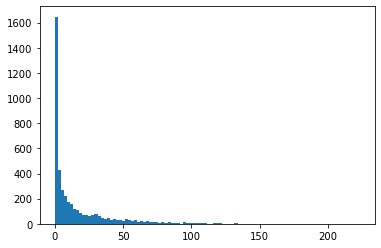

In [47]:
plt.hist(mean_precip, bins=100);
# plt.yscale('log')

In [69]:
cat_bins = np.arange(0, 102, 2, dtype='float')
cat_bins = np.append(np.insert(cat_bins, 1, 0.01), np.inf)
len(cat_bins)

53

In [70]:
cat_bins

array([0.0e+00, 1.0e-02, 2.0e+00, 4.0e+00, 6.0e+00, 8.0e+00, 1.0e+01,
       1.2e+01, 1.4e+01, 1.6e+01, 1.8e+01, 2.0e+01, 2.2e+01, 2.4e+01,
       2.6e+01, 2.8e+01, 3.0e+01, 3.2e+01, 3.4e+01, 3.6e+01, 3.8e+01,
       4.0e+01, 4.2e+01, 4.4e+01, 4.6e+01, 4.8e+01, 5.0e+01, 5.2e+01,
       5.4e+01, 5.6e+01, 5.8e+01, 6.0e+01, 6.2e+01, 6.4e+01, 6.6e+01,
       6.8e+01, 7.0e+01, 7.2e+01, 7.4e+01, 7.6e+01, 7.8e+01, 8.0e+01,
       8.2e+01, 8.4e+01, 8.6e+01, 8.8e+01, 9.0e+01, 9.2e+01, 9.4e+01,
       9.6e+01, 9.8e+01, 1.0e+02,     inf])

In [71]:
X, y = ds_train[600]
X.shape, y.shape

((1, 16, 16), (1, 128, 128))

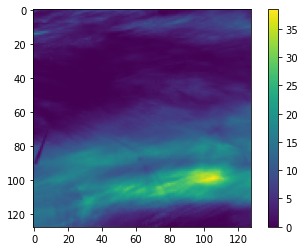

In [72]:
plt.imshow(y[0])
plt.colorbar();

In [76]:
def to_categorical(y, num_classes=None, dtype='float32'):
    """Copied from keras source code
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [88]:
a = pd.cut(y.reshape(-1), cat_bins, labels=False, include_lowest=True).reshape(y.shape)
a.shape

(1, 128, 128)

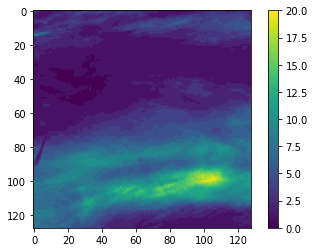

In [89]:
plt.imshow(a[0])
plt.colorbar();

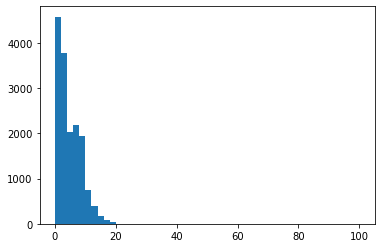

In [93]:
plt.hist(a.flat, bins=cat_bins);

In [94]:
a = to_categorical(a.squeeze(), num_classes=len(cat_bins))

In [95]:
a = np.rollaxis(a, 2)

In [96]:
a.shape

(53, 128, 128)

In [105]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-01'),
    first_days=5,
    scale=True,
    cat_bins=cat_bins
#     split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [106]:
X, y = ds_train[600]
X.shape, y.shape

((1, 16, 16), (53, 128, 128))

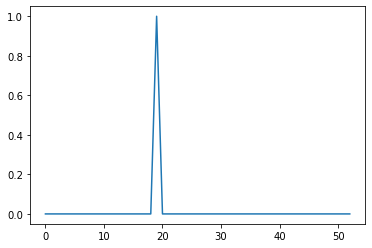

In [107]:
plt.plot(y[:, 100, 100])

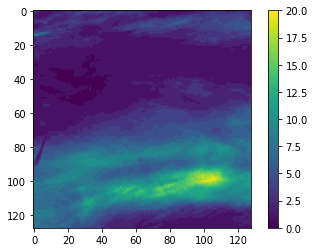

In [108]:
plt.imshow(np.argmax(y, 0))
plt.colorbar()